# Twitter Multi-Network Crawl/Query => Graph

## i. Load & Initialize

In [37]:
#!pip install python-decouple
#!pip install trio
import json
import tweepy
import re
from collections import Counter
import time
from decouple import config
import trio
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

## ii. Load Twitter Credentials

In [38]:
# if running in colab, upload `.env` as `env` then run:
#!mv env .env

#Load Twitter Credentials File
TWITTER_AUTH = tweepy.OAuthHandler(config('TWITTER_CONSUMER_KEY'),config('TWITTER_CONSUMER_SECRET'))
TWITTER_AUTH.set_access_token(config('TWITTER_ACCESS_TOKEN'),config('TWITTER_ACCESS_TOKEN_SECRET'))
TWITTER = tweepy.API(TWITTER_AUTH)

## 1. Capture current TwiterAPI rate limit status

In [39]:
# Check the limit before running the function, then check again after and compare. 
start_api_check = TWITTER.rate_limit_status()
limits_alpha = json_normalize(start_api_check)

## 2.  Function: Retrieve User Interactions

In [40]:
async def async_get_user_interactions(search, output, next_query, limit):
    """Crawls the targeted user's timeline and returns interactions.
    Args:
        `search`, string: The name of the user who's timeline to search.
        `output`, list of tuples: paired list of search & interaction targets. 
        `next_query`, list: a list of names to search on the next run. 
        `limit`, int: A flag to indicate how many results should be returned. 
    
    Functionality:
        Initialize search for the specific user.
        Get the user's tweets from their timeline. 
        Cycle through all the tweets' text and join it into a mega-string.
        Do some standardizing and replacing.
        Strip away everything except usernames, into a string. 
        Make a list of the counts, and take the top (X) most common people. 
        Creates a list of the `top` people. No duplicates 
        Tuple the results of the search & output together.
        Make search inputs for the next level of crawling.
    
    Returns:
        This function is async and has no return statement, rather it 
        instead updates the values of `output` and `next_query` extending
        the lists that were passed to it as args.
    """
    try:
        twitter_user = TWITTER.get_user(search)
        tweets = twitter_user.timeline(
                    count=200,
                    exclude_replies=False,
                    include_rts=True,
                    tweet_mode='extended'
        )
        b = [ i.full_text for i in tweets ]
        b = " ".join(b)
        b = b.lower()
        b = b.replace(search, "")
        out = re.findall(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)',b)
        top = Counter(out).most_common(limit)

        if limit > 0:
            interactions = []
            for interaction_count in top:
                interactions += ([interaction_count[0]] * interaction_count[1])

            tweet_data = [(search, i) for i in interactions]
            output.extend(tweet_data)

            next_target_users = [person[0] for person in top]
            next_query.extend(next_target_users)

        elif limit == -1: 

            # Tuple the results of the search & output together.
            tweet_data = [(search, i) for i in out]
            output = output.extend(tweet_data)
            
    except tweepy.TweepError:
        print("tweepy.TweepError=")
        
    except:
        e = sys.exc_info()[0]
        print("Error: %s" % e)

## 2. Async multi-query using Trio to retrieve data

In [43]:
origin_user = ['bwinterrose']
first_users = ['austen','paulg','justinkhan','tommycollison',"lambdaschool"]

async def interaction_chain(origin_user,first_users):
    """Calls our async function & loops through it for each target user."""
    # input settings
    
    first_limit = 10 # -1 is no limit, anything above 1 sets limit.
    second_limit = 5 # -1 is no limit, anything above 1 sets limit. 
    third_limit = 5
    
    # init function variables
    level = 0
    data = []
    last = 2 # Set to number of levels. 
    start_time = time.time()
    last_time = time.time()
    next_users = first_users
    checked_users = origin_user

    # Updates the time for each loop.
    def funct_time(last, d, l):
        now = time.time()
        check_time = now - last
        print("\n\nLevel %s Completed\nLevel %s time to complete: %s." % (l, l, check_time))
        print("Level %s interactions found:", (l, len(d)))
        return now
    
    # Dedupe & Check user list for previous runs (no duplicated work). 
    def update_lists(x, y, l, l_n):
        # de-duplicate it.
        x = list(dict.fromkeys(x))
        # remove any users already searched
        for i in y:
            a = np.array(x)
            a = a[a != i]
            x = a.tolist()
        # add new values to the checked_list
        y += x
        # on first run.... 
        if l == 0:
            l += 1 
            print("----------Entering %sst level. Searching the following users:----------\n" % (l), x)
        # on other runs...
        else: 
            print("Level %s connections found:" % (l), len(x),"\n\n")
            if l_n > (l):
                l += 1
                print("---------Beginning Level %s - Searching the following users:\n" % (l), x) 
        return x, y, l
    

    next_users, checked_users, level = update_lists(next_users, checked_users, level, last)
        
        
    # Level 1 Run.
    loop_num = 1
    async with trio.open_nursery() as nursery:
        for user in first_users:
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            nursery.start_soon(async_get_user_interactions, user, data, next_users, first_limit)
    
    last_time = funct_time(last_time, data, level)
    next_users, checked_users, level = update_lists(next_users, checked_users, level, last)


    # Level 2 Run.
    loop_num = 1
    async with trio.open_nursery() as nursery:
        for user in next_users:
            print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
            loop_num +=1
            nursery.start_soon(async_get_user_interactions, user, data, next_users, second_limit)
    
    last_time = funct_time(last_time, data, level)
    next_users, checked_users, level = update_lists(next_users, checked_users, level, last)


#     # Level 3 Run. Uncomment to run
#     loop_num = 1
#     async with trio.open_nursery() as nursery:
#         for user in next_users:
#             print("Loop # ", loop_num, " . Time so far:", time.time() - start_time)
#             loop_num +=1
#             nursery.start_soon(async_get_user_interactions, user, data, next_users, third_limit)
    
#     last_time = funct_time(last_time, data, level)
#     next_users, checked_users, level = update_lists(next_users, checked_users, level, last)
    
    print("Total time:", time.time() - start_time)
    print("Total Connections found:", (len(checked_users)-1))
    print("Total Overall Interactions found:", len(data))
    return data

## 3. Call the async `Trio` function. 

In [44]:
data = trio.run(interaction_chain,origin_user,first_users)

----------Entering 1st level. Searching the following users:----------
 ['austen', 'paulg', 'justinkhan', 'tommycollison', 'lambdaschool']
Loop #  1  . Time so far: 0.0004956722259521484
Loop #  2  . Time so far: 0.0004956722259521484
Loop #  3  . Time so far: 0.0004956722259521484
Loop #  4  . Time so far: 0.0004956722259521484
Loop #  5  . Time so far: 0.0004956722259521484


Level 1 Completed
Level 1 time to complete: 5.171893835067749.
Level %s interactions found: (1, 362)
Level 1 connections found: 32 


---------Beginning Level 2 - Searching the following users:
 ['amasad', 'mckaywrigley', 'kevinsimler', 'atabarrok', 'webdevmason', 'lpolovets', 'tesla', 'stephansturges', 'zewesk', 'honestduane', 'stevenglinert', 'ryanallred', 'hashim_warren', 'jasonsbarr', 'mandalane_', 'kailavansumer', 'shl', 'durbdawg', 'dustint314', 'meaghanbarber9', 'bri_theengineer', 'nickjbasile', 'mispelledtoyota', 'danielgross', 'nandotheessen', 'calebhicks', 'trevmckendrick', 'mitchellbwright', 'ouraring

## 4. Prep the data for conversion into a `networkx MultiDiGraph` object

In [7]:
# DF before Groupby
df = pd.DataFrame(data, columns=['source_user', 'interaction_user'])
display(df.shape)
display(df.head(5))

# Create groupby counts
df_group = df.groupby(['source_user','interaction_user']).size().reset_index().rename(columns={0: "count"})
display(df_group.head())
display(df_group.shape)

# Create "Normalized" interaction weights for each user's interactions. 
a = df_group.groupby('source_user')['count'].transform('sum')
df_group['weight'] = df_group['count'].div(a)
display(df_group.head())
display(df_group.shape)

(2254, 2)

,source_user,interaction_user
0,tommycollison,lambdaschool
1,tommycollison,lambdaschool
2,tommycollison,lambdaschool
3,tommycollison,lambdaschool
4,tommycollison,lambdaschool


,source_user,interaction_user,count
0,amasad,hazthewaz0001,5
1,amasad,kognise,7
2,amasad,nicklovescode,6
3,amasad,paulg,8
4,amasad,replit,48


(195, 3)

,source_user,interaction_user,count,weight
0,amasad,hazthewaz0001,5,0.067568
1,amasad,kognise,7,0.094595
2,amasad,nicklovescode,6,0.081081
3,amasad,paulg,8,0.108108
4,amasad,replit,48,0.648649


(195, 4)

## 5. Convert the Pandas Dataframe to Networkx Graph

In [8]:
%%time
# Create the graph object 
DG = nx.from_pandas_edgelist(df_group, "source_user", "interaction_user",
                            edge_attr=['weight', "count"], 
                             create_using=nx.MultiGraph())

# Check how many nodes are on the graph now. 
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

Wall time: 2.01 ms


In [9]:
bicomponents = list(nx.biconnected_components(DG))
len(bicomponents)

108

## 6. Graph the Networkx graph objects. 

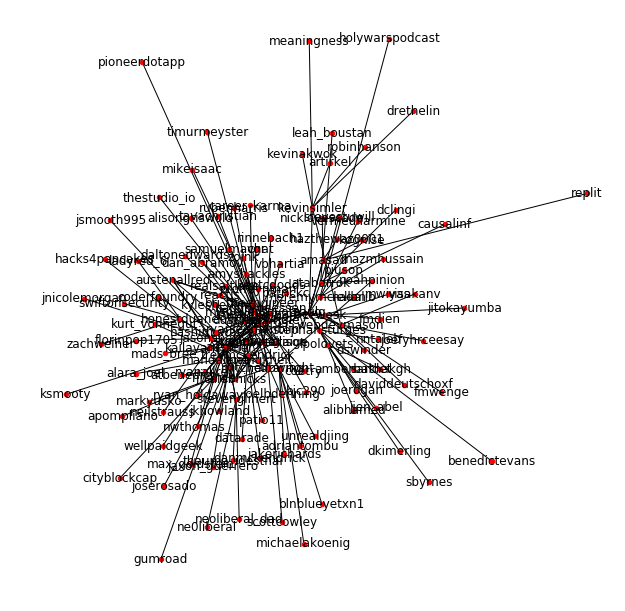

Wall time: 1.57 s


In [10]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_kamada_kawai(DG,node_size=20,with_labels=True)
plt.show()

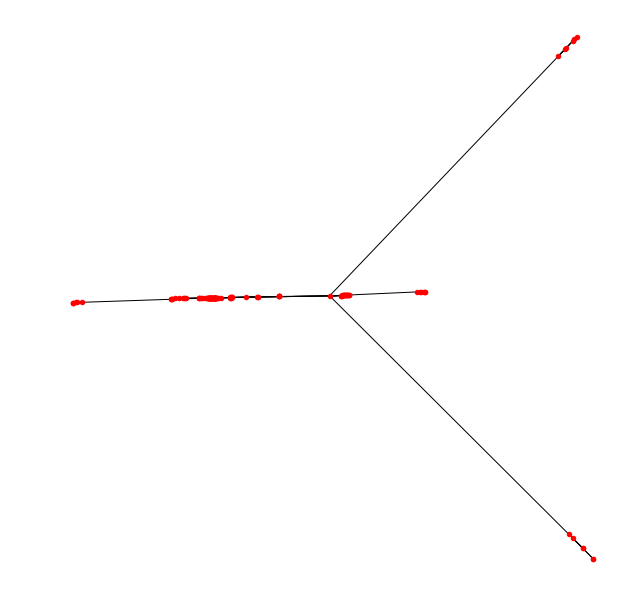

Wall time: 133 ms


In [11]:
%%time
fig = plt.figure(figsize=(8,8))
nx.draw_spectral(DG, node_size=20)
plt.show()

## 7. Query TwitterAPI and Inspect Rate Usage

In [12]:
# Query API 
end_api_check = TWITTER.rate_limit_status()
limits_beta = json_normalize(end_api_check).T
limits_beta.rename(columns = {0:'beta',}, inplace = True)

# Compare the change of ALL API ENDPOINTS between limits, alpha (before run), and beta (after run.)
limits_delta = limits_alpha.T.copy()
limits_delta['beta'] = limits_beta['beta']
limits_delta = limits_delta.reset_index(drop=False)
limits_delta.rename(columns = {0:'alpha', 'index':'api_endpoint'}, inplace = True)
limits_delta = limits_delta[['api_endpoint','alpha', 'beta']].assign(delta=limits_delta.alpha != limits_delta.beta)
limits_delta['type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 1, expand = True)[0]
limits_delta['sub_type'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[1]
limits_delta['api_path'] = limits_delta.api_endpoint.str.split(pat = '.', n = 2, expand = True)[2].str.rsplit(pat = '.', n = 1, expand = True)[0]
limits_delta['method'] = limits_delta.api_path.str.rsplit(pat = '/', n = 1, expand = True)[1]
limits_delta['stat'] = limits_delta.api_endpoint.str.rsplit(pat = '.', n = 1, expand = True)[1]
limits_delta = limits_delta[['type', 'sub_type', 'api_path', 'method', 'stat', 'alpha', 'beta', 'delta']]

# Display filtered df. 
limits_delta[(limits_delta['stat'].str.contains("reset") == False) & (limits_delta['delta']==True)]


,type,sub_type,api_path,method,stat,alpha,beta,delta
50,resources,application,/application/rate_limit_status,rate_limit_status,remaining,179,178,True
365,resources,statuses,/statuses/user_timeline,user_timeline,remaining,900,864,True
431,resources,users,/users/show/:id,:id,remaining,900,864,True
